In [1]:
#H: importing the initial libraries

import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt


# **1- DATA PROCESSING AND MANIPULATION**


In [2]:
#H: uploading the dataset
my_df = pd.read_parquet("/kaggle/input/whalesann-ds/train-00015-of-00019.parquet")

In [3]:
my_df.head()

,image,species,species_name,individual,individual_name
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,12,pilot_whale,1140,9ca8c8c44aad
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,1141,043c35dbc47f
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,fin_whale,1143,eb5f1e9e2dd3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,bottlenose_dolphin,1146,7d6feb4d350b
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,25,short_finned_pilot_whale,1152,40796b7275d3


In [4]:
#H: informations about the dataset
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            2246 non-null   object
 1   species          2246 non-null   int64 
 2   species_name     2246 non-null   object
 3   individual       2246 non-null   int64 
 4   individual_name  2246 non-null   object
dtypes: int64(2), object(3)
memory usage: 87.9+ KB


In [5]:
#H: the species existing in the dataset
my_df['species_name'].value_counts()

species_name
dusky_dolphin                601
humpback_whale               445
melon_headed_whale           273
blue_whale                   233
spinner_dolphin              118
southern_right_whale          78
fin_whale                     72
beluga                        62
bottlenose_dolphin            44
pilot_whale                   41
spotted_dolphin               38
white_sided_dolphin           37
killer_whale                  27
cuviers_beaked_whale          26
sei_whale                     21
gray_whale                    16
commersons_dolphin            15
short_finned_pilot_whale      14
false_killer_whale            13
bottlenose_dolpin             13
long_finned_pilot_whale       11
minke_whale                    9
pantropic_spotted_dolphin      8
rough_toothed_dolphin          8
globis                         6
brydes_whale                   6
common_dolphin                 4
frasiers_dolphin               4
pygmy_killer_whale             2
kiler_whale                   

In [6]:
#H: as some classes have typing mistakes we correct them to organize the data
my_df['species_name'] = my_df['species_name'].replace({
    'bottlenose_dolpin': 'bottlenose_dolphin',
    'kiler_whale': 'killer_whale'
})
species_counts = my_df['species_name'].value_counts()
species_counts

species_name
dusky_dolphin                601
humpback_whale               445
melon_headed_whale           273
blue_whale                   233
spinner_dolphin              118
southern_right_whale          78
fin_whale                     72
beluga                        62
bottlenose_dolphin            57
pilot_whale                   41
spotted_dolphin               38
white_sided_dolphin           37
killer_whale                  28
cuviers_beaked_whale          26
sei_whale                     21
gray_whale                    16
commersons_dolphin            15
short_finned_pilot_whale      14
false_killer_whale            13
long_finned_pilot_whale       11
minke_whale                    9
pantropic_spotted_dolphin      8
rough_toothed_dolphin          8
globis                         6
brydes_whale                   6
common_dolphin                 4
frasiers_dolphin               4
pygmy_killer_whale             2
Name: count, dtype: int64

In [7]:
#H: undersampling the dataset for a balanced one (we chose the 4 classes with most samples)

filtered_df = pd.concat([
    my_df[my_df['species_name'] == 'dusky_dolphin'].sample(n=273, random_state=42),
    my_df[my_df['species_name'] == 'humpback_whale'].sample(n=273, random_state=42),
    my_df[my_df['species_name'] == 'melon_headed_whale'],  # Already 273
    my_df[my_df['species_name'] == 'blue_whale']          # Keep all 233 (or sample 233 if needed)
])

# Verify counts
print(filtered_df['species_name'].value_counts())

species_name
dusky_dolphin         273
humpback_whale        273
melon_headed_whale    273
blue_whale            233
Name: count, dtype: int64


In [8]:
filtered_df.head()

,image,species,species_name,individual,individual_name
420,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,2374,b732f036d071
1570,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,5170,9ffedbf00298
2098,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,6168,35bcf0bbb18c
285,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,1988,d7bcf851a9db
721,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,13,dusky_dolphin,3205,6063cf5f5c18


In [9]:
#H: let's check the image column state (our dataset now is filtered_df)
first_image = filtered_df['image'].iloc[0]
print("First image data type:", type(first_image))
print("Dictionary keys:", first_image.keys()) 

First image data type: <class 'dict'>
Dictionary keys: dict_keys(['bytes', 'path'])


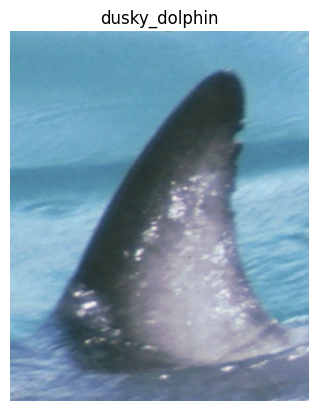

In [10]:
#H: check if the images are readable
from PIL import Image
import io

img_bytes = filtered_df.loc[420, 'image']['bytes']
img = Image.open(io.BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title(filtered_df.loc[420, 'species_name'])
plt.show()

In [11]:
#H: creating the directories to store the data and files (model,encoder)

os.makedirs('data', exist_ok=True)
os.makedirs('preprocessing', exist_ok=True)

In [12]:
#H: resizing the images and processing the labels

import pickle
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor

IMAGE_SIZE = (128, 128)

#H: the function for resizing the images
def process_image(row):
    try:
        img = Image.open(io.BytesIO(row['image']['bytes'])).convert('RGB')
        img = img.resize(IMAGE_SIZE)
        return np.array(img)
    except Exception as e:
        print(f"Error processing image: {e}")
        return np.zeros((*IMAGE_SIZE, 3))  # Return blank image if error

# Parallel processing
with ThreadPoolExecutor(max_workers=8) as executor:
    X = list(executor.map(process_image, [row for _, row in filtered_df.iterrows()]))

# Convert and normalize
X = np.array(X, dtype=np.float32) / 255.0

# Label encoding
le = LabelEncoder()
y = le.fit_transform(filtered_df['species_name'])

# Save artifacts for interface
with open('preprocessing/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save sample mean/std for future normalization (if needed)
stats = {'mean': np.mean(X), 'std': np.std(X)}
with open('preprocessing/image_stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

In [13]:
#H: spliting the data to 3 groups (train, test, and validation)

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# First split (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Second split (50% val, 50% test of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


# One-hot encode the labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Save splits
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)
np.save('data/X_val.npy', X_val)
np.save('data/y_val.npy', y_val)
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)

print(f"""
Processing Complete : \n
Train: {X_train.shape} ({len(y_train)} samples)
Val: {X_val.shape} ({len(y_val)} samples)
Test: {X_test.shape} ({len(y_test)} samples)
Classes: {le.classes_}
""")

2025-05-19 11:33:44.511551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747654424.768226      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747654424.847152      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Processing Complete : 

Train: (841, 128, 128, 3) (841 samples)
Val: (105, 128, 128, 3) (105 samples)
Test: (106, 128, 128, 3) (106 samples)
Classes: ['blue_whale' 'dusky_dolphin' 'humpback_whale' 'melon_headed_whale']



In [14]:
#H: make sure or the samples are correct and no data corrupted

assert not np.allclose(X[0], np.zeros((*IMAGE_SIZE, 3))), "Blank image detected"

for name, arr in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    labels = np.argmax(arr, axis=1)
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{name} class distribution:")
    for cls, count in zip(le.classes_[unique], counts):
        print(f"  {cls}: {count}")

Train class distribution:
  blue_whale: 187
  dusky_dolphin: 218
  humpback_whale: 218
  melon_headed_whale: 218
Val class distribution:
  blue_whale: 23
  dusky_dolphin: 28
  humpback_whale: 27
  melon_headed_whale: 27
Test class distribution:
  blue_whale: 23
  dusky_dolphin: 27
  humpback_whale: 28
  melon_headed_whale: 28


# **2- DEFINITION & TRAINING OF THE FIRST MODEL**

In [15]:
#H:importing the necessary libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [16]:
#H: building the ANN model (layers)

ann_model = Sequential([
    Flatten(input_shape=(128,128,3)), #H:input layer -> transforme images to vectors
    
    Dense(1024, activation='relu', kernel_regularizer='l2'), #H: hidden layer 1
    Dropout(0.6), #H: in order to prevent overfitting
    BatchNormalization(),  # Stabilizes training
    
    Dense(512, activation='relu'),#H: hidden layer 2
    Dropout(0.4),
    
    Dense(256, activation='relu'),  #H: hidden layer 3
    
    Dense(y_train.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-19 11:34:00.728516: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
#H: compiling the model and visualizing its summary
ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]       
)

In [18]:
#H: training the model

callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', verbose=1,  
                 restore_best_weights=True),
    ModelCheckpoint('my_best_whale_model1.keras', 
                  monitor='val_accuracy', mode='max',  
                  save_best_only=True)
]

training_history = ann_model.fit(
    X_train, y_train,
    batch_size=16,  
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 879ms/step - accuracy: 0.3287 - loss: 16.3009 - precision: 0.3389 - recall: 0.1111 - val_accuracy: 0.3810 - val_loss: 9.4105 - val_precision: 0.4062 - val_recall: 0.2476
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 988ms/step - accuracy: 0.3818 - loss: 8.2536 - precision: 0.4419 - recall: 0.1812 - val_accuracy: 0.2762 - val_loss: 7.5841 - val_precision: 0.3333 - val_recall: 0.1905
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4159 - loss: 7.2377 - precision: 0.4787 - recall: 0.1938 - val_accuracy: 0.3048 - val_loss: 7.4961 - val_precision: 0.3034 - val_recall: 0.2571
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 850ms/step - accuracy: 0.3788 - loss: 7.4571 - precision: 0.4688 - recall: 0.1590 - val_accuracy: 0.3143 - val_loss: 8.0594 - val_precision: 0.5238 - val_recall: 0.1048
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 911ms/step - accuracy: 0.3885 - loss: 8.0351 - precision: 0.4485 - recall: 0.1165 - val_accuracy: 0.4190 - val_loss:

In [19]:
#H: evaluation of the model (specifically the best model)

my_best_model = load_model('my_best_whale_model1.keras')

test_loss, test_accuracy, test_precision, test_recall = my_best_model.evaluate(X_test, y_test)

print(f"\nTest Metrics:")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision*100:.2f}%")  
print(f"Recall: {test_recall*100:.2f}%")       
print(f"Loss: {test_loss*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4375 - loss: 6.2805 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Metrics:
Accuracy: 42.45%
Precision: 0.00%
Recall: 0.00%
Loss: 628.73%


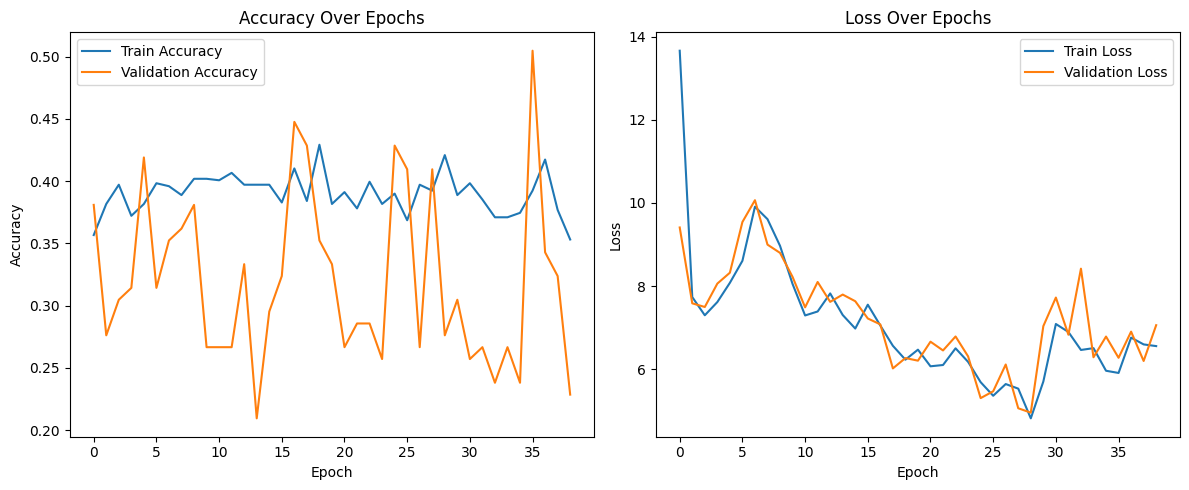

In [20]:
#H: Plotting training graphs (NEW)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('first_model_training_curves.png')
plt.show()

In [21]:
# Verify image normalization
print("Pixel range:", X_train.min(), X_train.max())  # Should be 0-1 or -1 to 1

# Apply class weighting during training
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', 
                                                classes=np.unique(np.argmax(y_train, axis=1)),
                                                y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

Pixel range: 0.0 1.0


Since the accuracy of this first model is very low we did some changes to improve its performance.

# **3- DEFINITION & TRAINING OF THE SECOND MODEL**

In [22]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [23]:

#H: defining the model
final_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),

    Dense(1024, kernel_regularizer=l2(0.0001)), 
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(512, kernel_regularizer=l2(0.0001)), 
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(256, kernel_regularizer=l2(0.0001)), 
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Dense(y_train.shape[1], activation='softmax')
])

#H: Compiling the model
final_model.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')] 
)

#H: Model Summary
print(final_model.summary())


final_callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True), 
    ModelCheckpoint('final_best_whale_model_v2.keras', save_best_only=True) 
]

# Training the model
final_training_history = final_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=150,  
    validation_data=(X_val, y_val),
    callbacks=final_callbacks,
    verbose=1
)

# Evaluation of the best model
final_best_model = load_model('final_best_whale_model_v2.keras') 

test_loss, test_accuracy, test_precision, test_recall = final_best_model.evaluate(X_test, y_test)
print(f"\nTest Metrics:")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision*100:.2f}%")  
print(f"Recall: {test_recall*100:.2f}%")
print(f"Loss: {test_loss*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      50,332,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,996,996 (194.54 MB)

 Trainable params: 50,993,412 (194.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

None
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4132 - loss: 1.7581 - precision: 0.4328 - recall: 0.2751 - val_accuracy: 0.4571 - val_loss: 1.4421 - val_precision: 0.6061 - val_recall: 0.3810
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6030 - loss: 1.2536 - precision: 0.6815 - recall: 0.4858 - val_accuracy: 0.4952 - val_loss: 1.3626 - val_precision: 0.5542 - val_recall: 0.4381
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - accuracy: 0.6440 - loss: 1.2108 - precision: 0.6886 - recall: 0.5291 - val_accuracy: 0.5429 - val_loss: 1.5000 - val_precision: 0.5281 - val_recall: 0.4476
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 846ms/step - accuracy: 0.6607 - loss: 1.1326 - precision: 0.7260 - recall: 0.5540 - val_accuracy: 0.5429 - val_loss: 1.4413 - val_precision: 0.5667 - val_recall: 0.4857
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6988 - loss: 1.0397 - precision: 0.7668 - recall: 0.6215 - val_accuracy: 0.5619 - val_lo

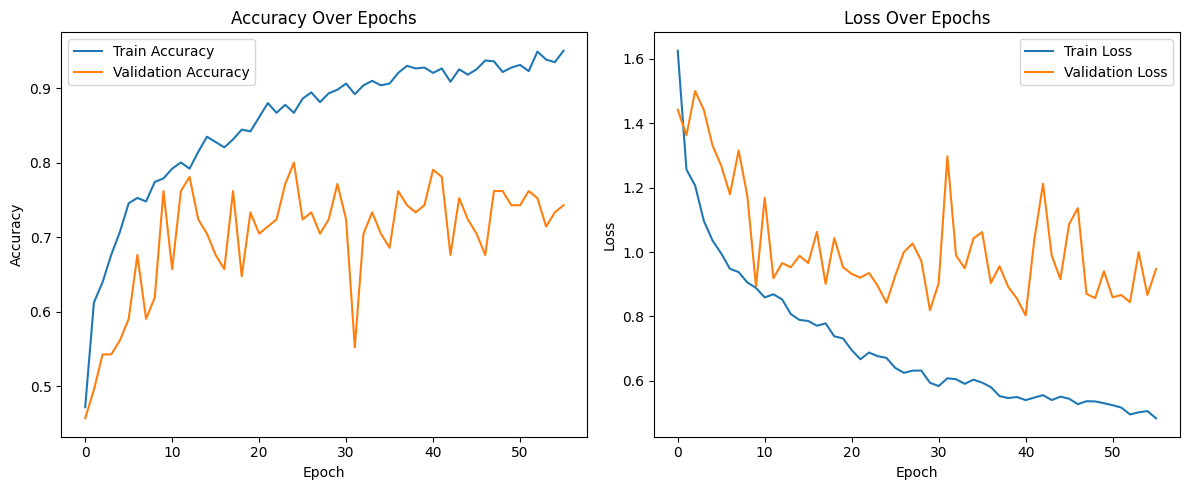

In [24]:
#H: Plotting training graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_training_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_training_history.history['loss'], label='Train Loss')
plt.plot(final_training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('final_model_training_curves.png')
plt.show()

**4- MORE METRICS OF THE FINAL MODEL**

In [25]:
#H: classification report of the final model
from sklearn.metrics import classification_report
class_names = list(le.classes_) 
y_pred = final_best_model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), 
                          np.argmax(y_pred, axis=1),
                          target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
                    precision    recall  f1-score   support

        blue_whale       0.94      0.70      0.80        23
     dusky_dolphin       0.96      0.85      0.90        27
    humpback_whale       0.69      0.86      0.76        28
melon_headed_whale       0.73      0.79      0.76        28

          accuracy                           0.80       106
         macro avg       0.83      0.80      0.81       106
      weighted avg       0.82      0.80      0.80       106



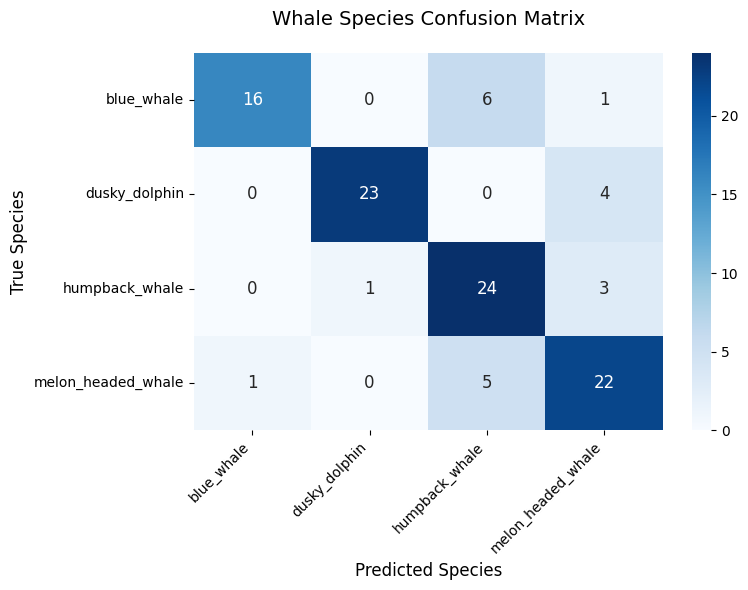

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                     np.argmax(y_pred, axis=1))

# Optimized visualization
plt.figure(figsize=(8, 6))  # Adjusted for 4 classes
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',  # Better color contrast
            annot_kws={"size": 12})  # Larger annotation font

plt.title('Whale Species Confusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Species', fontsize=12)
plt.ylabel('True Species', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Better label rotation
plt.yticks(rotation=0)
plt.tight_layout()  # Prevent label cutoff
plt.show()

# **5- MODEL CARD AND TEST**

In [27]:
model_card = {
    'Model Type': 'ANN',
    'Input Shape': (128, 128, 3),
    'Output Classes': len(class_names),
    'Test Accuracy': f"{test_accuracy*100:.2f}%",
    'Key Layers': [
        'Flatten',
        'Dense(1024)-BatchNorm-ReLU-Dropout',
        'Dense(512)-BatchNorm-ReLU-Dropout', 
        'Dense(256)-BatchNorm-ReLU-Dropout'
    ],
    'Optimizer': 'Adam(lr=0.00005)',
    'Regularization': 'L2(0.0001) + Dropout'
}

print("Model Card:")
for k, v in model_card.items():
    print(f"{k}: {v}")

Model Card:
Model Type: ANN
Input Shape: (128, 128, 3)
Output Classes: 4
Test Accuracy: 80.19%
Key Layers: ['Flatten', 'Dense(1024)-BatchNorm-ReLU-Dropout', 'Dense(512)-BatchNorm-ReLU-Dropout', 'Dense(256)-BatchNorm-ReLU-Dropout']
Optimizer: Adam(lr=0.00005)
Regularization: L2(0.0001) + Dropout


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


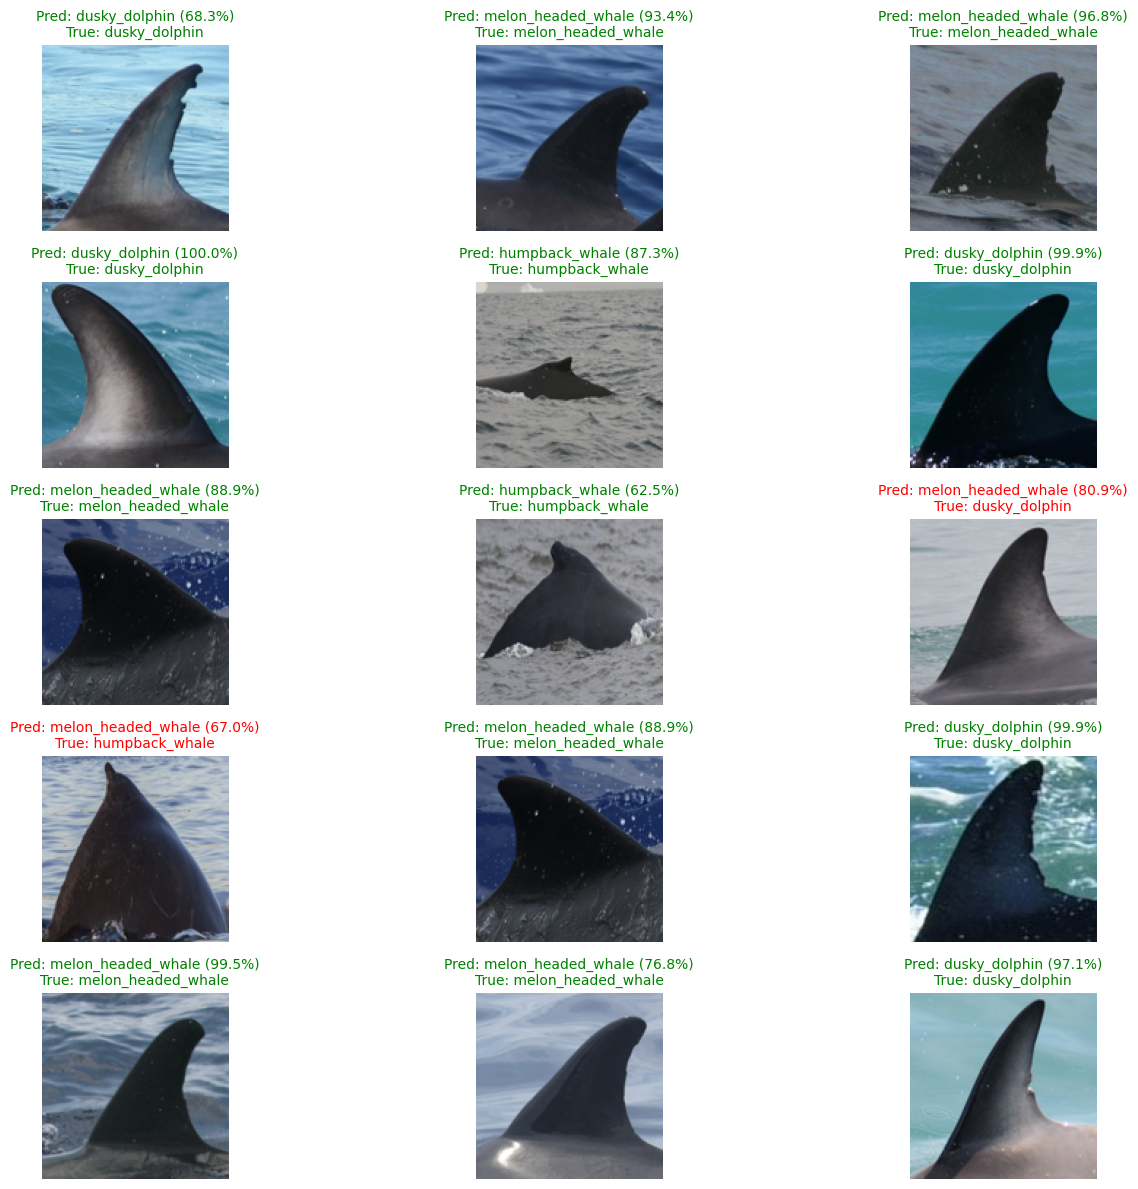

In [28]:
#H: testing the model

import random

def plot_random_whale(model, images, true_labels, classes):
    
    # Pick random index
    i = random.randint(0, len(images)-1)
    
    # Get prediction
    img = images[i]
    pred_probs = model.predict(np.expand_dims(img, axis=0))  # Add batch dimension
    pred_label = classes[np.argmax(pred_probs)]
    true_label = classes[np.argmax(true_labels[i])]
    
    # Plot image
    plt.imshow(img)
    plt.axis('off')
    
    # Set title color based on prediction correctness
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label} ({np.max(pred_probs)*100:.1f}%)\nTrue: {true_label}", 
              color=color,
              fontsize=10)

# Create a grid of random predictions
plt.figure(figsize=(15, 12))
for i in range(15):  # 15 examples
    plt.subplot(5, 3, i+1)
    plot_random_whale(
        model=final_best_model,
        images=X_test,
        true_labels=y_test,
        classes=class_names
    )
plt.tight_layout()
plt.show()